# Drag Coffi. Prediction: RegDGCNN architecture

## Mesh to Point Cloud: 
Mesh - STL file format
Issues with STL file format: Zero area traingle
1. **Mesh Loading and Cleaning**: Load and remove zero area triangle and duplicate
2. **Uniform Sampling** : Sample across surface, 5X times requested. 
3. **Normalize** : Centering, Scaling
4. **Farthes Point Sampling** : Selectes points
5. **Storage**: Save in .npz file

## Dataset Creation: Loading, spliting

### Dataset Class

In [5]:
import os
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset
from typing import Optional, List, Callable, Tuple


class DrivAerPointCloudDataset(Dataset):
    """
    Dataset for preprocessed DrivAer point clouds stored as NPZ files.
    Optimized for data that is already normalized and fixed-size.
    """

    def __init__(
        self,
        root_dir: str,
        csv_file: str,
        transform: Optional[Callable] = None
    ):
        """
        Args:
            root_dir (str): Directory containing .npz point cloud files.
            csv_file (str): CSV file with columns [ID, Drag_Value].
            transform (Callable, optional): Optional transform (e.g., torch-specific ops).
        """
        self.root_dir = root_dir
        self.data_frame = pd.read_csv(csv_file)
        self.transform = transform

        # Standardizing column names to avoid whitespace issues
        self.data_frame.columns = self.data_frame.columns.str.strip()
        
        # Sanity check
        assert "ID" in self.data_frame.columns, "CSV must contain 'ID' column"
        assert "Drag_Value" in self.data_frame.columns, "CSV must contain 'Drag_Value' column"

    def __len__(self) -> int:
        return len(self.data_frame)

    def _load_npz(self, design_id: str) -> torch.Tensor:
        # Ensure design_id is treated as string for filename
        path = os.path.join(self.root_dir, f"{str(design_id)}.npz")

        if not os.path.exists(path):
            raise FileNotFoundError(f"Missing file: {path}")

        # Use context manager to ensure the file is closed properly
        with np.load(path) as data:
            points = data["points"]  # Shape: (4096, 3)

        if points.shape != (4096, 3):
            raise ValueError(f"Shape mismatch for {design_id}: Expected (4096,3), got {points.shape}")

        return torch.from_numpy(points).float()

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor]:
        row = self.data_frame.iloc[idx]
        design_id = row["ID"]
        drag_value = row["Drag_Value"]

        # 1. Load the point cloud
        points = self._load_npz(design_id)

        # 2. Optional transform (for specific PyTorch formatting if needed)
        if self.transform is not None:
            points = self.transform(points)

        # 3. Label as a 1D tensor (Standard for MSELoss)
        drag = torch.tensor([drag_value], dtype=torch.float32)

        return points, drag
    
    def split_data(
    self,
    train_ratio: float = 0.7,
    val_ratio: float = 0.15,
    test_ratio: float = 0.15,
    seed: int = 42
    ) -> Tuple[List[int], List[int], List[int]]:
        """
        Splits the dataset into training, validation, and test sets.

        Returns:
            train_indices, val_indices, test_indices
        """
        assert abs(train_ratio + val_ratio + test_ratio - 1.0) < 1e-6, \
            "Ratios must sum to 1"

        num_samples = len(self)
        indices = np.arange(num_samples)

        # Reproducible shuffle
        rng = np.random.default_rng(seed)
        rng.shuffle(indices)

        train_end = int(train_ratio * num_samples)
        val_end = train_end + int(val_ratio * num_samples)

        train_indices = indices[:train_end].tolist()
        val_indices   = indices[train_end:val_end].tolist()
        test_indices  = indices[val_end:].tolist()

        return train_indices, val_indices, test_indices

- Fetch the Point Cloud and corresponding drag value
- Convert it into PyTorch Tensor
- return (points, drag)

### Sanity Check of Dataset Class

In [3]:
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

def run_dataset_sanity_check(dataset, batch_size=4):
    print("=== DrivAerPointCloudDataset Sanity Check ===")
    
    # 1. Check Length
    total_samples = len(dataset)
    print(f"Total samples in dataset: {total_samples}")
    if total_samples == 0:
        print("❌ Error: Dataset is empty. Check your CSV path.")
        return

    # 2. Test Single Item Fetching
    try:
        pc, label = dataset[0]
        print(f"Single sample check:")
        print(f" - Point cloud shape: {pc.shape} (Expected: [4096, 3])")
        print(f" - Label shape: {label.shape} (Expected: [1])")
        print(f" - Point cloud dtype: {pc.dtype}")
        print(f" - Label dtype: {label.dtype}")
    except Exception as e:
        print(f"❌ Error fetching single item: {e}")
        return

    # 3. Check Normalization Range
    # Since you mentioned data is pre-normalized, we verify the bounds
    pc_min, pc_max = pc.min().item(), pc.max().item()
    print(f" - Point cloud range: [{pc_min:.4f}, {pc_max:.4f}]")
    if pc_min < -5.0 or pc_max > 5.0: # Broad check for standard normalization
        print("⚠️ Warning: Point cloud values seem large. Double-check your normalization.")

    # 4. Check DataLoader (Batching & Parallelism)
    try:
        loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=0)
        batch_pc, batch_label = next(iter(loader))
        print(f"Batching check (Batch Size: {batch_size}):")
        print(f" - Batch PC shape: {batch_pc.shape} (Expected: [{batch_size}, 4096, 3])")
        print(f" - Batch Label shape: {batch_label.shape} (Expected: [{batch_size}, 1])")
    except Exception as e:
        print(f"❌ Error during batch loading: {e}")
        return

    # 5. Check for NaNs
    if torch.isnan(batch_pc).any() or torch.isnan(batch_label).any():
        print("❌ Error: Found NaN values in the data.")
    else:
        print("✅ No NaN values detected.")

    print("\n=== All basic sanity checks passed! ===")

# Example Usage:
my_dataset = DrivAerPointCloudDataset(root_dir='02_dataset/car_4096_pc/pc_processed', csv_file='02_dataset/cd_values/DrivAerNetPlusPlus_Cd_504.csv')
run_dataset_sanity_check(my_dataset)

=== DrivAerPointCloudDataset Sanity Check ===
Total samples in dataset: 500
Single sample check:
 - Point cloud shape: torch.Size([4096, 3]) (Expected: [4096, 3])
 - Label shape: torch.Size([1]) (Expected: [1])
 - Point cloud dtype: torch.float32
 - Label dtype: torch.float32
 - Point cloud range: [-0.9898, 0.9439]
Batching check (Batch Size: 4):
 - Batch PC shape: torch.Size([4, 4096, 3]) (Expected: [4, 4096, 3])
 - Batch Label shape: torch.Size([4, 1]) (Expected: [4, 1])
✅ No NaN values detected.

=== All basic sanity checks passed! ===


In [4]:
import torch
import numpy as np
from torch.utils.data import DataLoader

def sanity_check_dataset(dataset, batch_size=8, num_samples_to_check=5):
    print("=" * 60)
    print("Running Sanity Check for DrivAerPointCloudDataset")
    print("=" * 60)

    # --------------------------------------------------
    # 1. Dataset length
    # --------------------------------------------------
    print(f"Dataset size: {len(dataset)}")
    assert len(dataset) > 0, "Dataset is empty!"

    # --------------------------------------------------
    # 2. Single-sample check
    # --------------------------------------------------
    for i in range(min(num_samples_to_check, len(dataset))):
        points, drag = dataset[i]

        print(f"\nSample {i}:")
        print(f"  Points shape: {points.shape}")
        print(f"  Points dtype: {points.dtype}")
        print(f"  Drag shape:   {drag.shape}")
        print(f"  Drag value:   {drag.item():.6f}")

        # Shape checks
        assert points.shape == (4096, 3), "Point cloud shape mismatch"
        assert drag.shape == (1,), "Drag label must be shape (1,)"

        # Value checks
        assert torch.isfinite(points).all(), "NaN or Inf found in points"
        assert torch.isfinite(drag).all(), "NaN or Inf found in label"

        # Range checks (already normalized)
        max_abs = points.abs().max().item()
        print(f"  Max |coord|: {max_abs:.4f}")
        assert max_abs < 5.0, "Point values seem unreasonably large"

    # --------------------------------------------------
    # 3. DataLoader check
    # --------------------------------------------------
    loader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=0,
        drop_last=False
    )

    points_batch, drag_batch = next(iter(loader))

    print("\nBatch check:")
    print(f"  Points batch shape: {points_batch.shape}")
    print(f"  Drag batch shape:   {drag_batch.shape}")

    assert points_batch.shape == (batch_size, 4096, 3), "Batch point shape mismatch"
    assert drag_batch.shape == (batch_size, 1), "Batch label shape mismatch"

    # --------------------------------------------------
    # 4. Statistical sanity
    # --------------------------------------------------
    mean = points_batch.mean(dim=(0, 1))
    std = points_batch.std(dim=(0, 1))

    print("\nPoint cloud statistics (batch):")
    print(f"  Mean (x,y,z): {mean.tolist()}")
    print(f"  Std  (x,y,z): {std.tolist()}")

    assert (std > 0).all(), "Zero variance detected in point cloud"

    print("\n✅ Sanity check PASSED")
    print("=" * 60)
    
    

dataset = DrivAerPointCloudDataset(
    root_dir='02_dataset/car_4096_pc/pc_processed', csv_file='02_dataset/cd_values/DrivAerNetPlusPlus_Cd_504.csv'
)

sanity_check_dataset(dataset)



Running Sanity Check for DrivAerPointCloudDataset
Dataset size: 500

Sample 0:
  Points shape: torch.Size([4096, 3])
  Points dtype: torch.float32
  Drag shape:   torch.Size([1])
  Drag value:   0.275833
  Max |coord|: 0.9898

Sample 1:
  Points shape: torch.Size([4096, 3])
  Points dtype: torch.float32
  Drag shape:   torch.Size([1])
  Drag value:   0.279602
  Max |coord|: 0.9952

Sample 2:
  Points shape: torch.Size([4096, 3])
  Points dtype: torch.float32
  Drag shape:   torch.Size([1])
  Drag value:   0.272837
  Max |coord|: 0.9993

Sample 3:
  Points shape: torch.Size([4096, 3])
  Points dtype: torch.float32
  Drag shape:   torch.Size([1])
  Drag value:   0.257712
  Max |coord|: 0.9981

Sample 4:
  Points shape: torch.Size([4096, 3])
  Points dtype: torch.float32
  Drag shape:   torch.Size([1])
  Drag value:   0.267890
  Max |coord|: 0.9882

Batch check:
  Points batch shape: torch.Size([8, 4096, 3])
  Drag batch shape:   torch.Size([8, 1])

Point cloud statistics (batch):
  Mean 

In [19]:
import torch
from torch.utils.data import DataLoader, Subset

def run_split_sanity_check(dataset):
    print("--- Starting Dataset & Split Sanity Check ---")
    
    # 1. Test the split_data method
    try:
        train_idx, val_idx, test_idx = dataset.split_data(
            train_ratio=0.7, val_ratio=0.15, test_ratio=0.15, seed=42
        )
    except Exception as e:
        print(f"❌ split_data method failed: {e}")
        return

    # 2. Check overlap and completeness
    all_indices = set(train_idx) | set(val_idx) | set(test_idx)
    overlap = len(train_idx) + len(val_idx) + len(test_idx) != len(all_indices)
    
    print(f"Total Samples: {len(dataset)}")
    print(f"Train: {len(train_idx)}, Val: {len(val_idx)}, Test: {len(test_idx)}")
    
    if overlap:
        print("❌ Error: There is an overlap between your split indices!")
    else:
        print("✅ No index overlap detected.")

    if len(all_indices) != len(dataset):
        print(f"⚠️ Warning: Split total ({len(all_indices)}) does not match dataset size ({len(dataset)}).")
    else:
        print("✅ Split covers 100% of the dataset.")

    # 3. Test Reproducibility
    t2, _, _ = dataset.split_data(seed=42)
    if train_idx == t2:
        print("✅ Split is reproducible with the same seed.")
    else:
        print("❌ Error: Split is not reproducible. Check your RNG usage.")

    # 4. Check DataLoader Integration
    try:
        # Create a subset using the indices
        train_subset = Subset(dataset, train_idx)
        # Use a small batch size for the check
        loader = DataLoader(train_subset, batch_size=4, shuffle=True)
        
        # Pull one batch
        points, drag = next(iter(loader))
        
        print("\nBatch Loading Check:")
        print(f" - Point Cloud Batch Shape: {points.shape}") # Expected: [4, 4096, 3]
        print(f" - Drag Value Batch Shape: {drag.shape}")    # Expected: [4, 1]
        
        if torch.isnan(points).any():
            print("❌ Error: NaNs detected in point cloud data.")
        else:
            print("✅ Data loading successful with no NaNs.")

    except Exception as e:
        print(f"❌ DataLoader failed using indices: {e}")

    print("\n--- Sanity Check Complete ---")

# Usage:
dataset = DrivAerPointCloudDataset(root_dir='02_dataset/car_4096_pc/pc_processed', csv_file='02_dataset/cd_values/DrivAerNetPlusPlus_Cd_504.csv')
run_split_sanity_check(dataset)

--- Starting Dataset & Split Sanity Check ---
Total Samples: 500
Train: 350, Val: 75, Test: 75
✅ No index overlap detected.
✅ Split covers 100% of the dataset.
✅ Split is reproducible with the same seed.

Batch Loading Check:
 - Point Cloud Batch Shape: torch.Size([4, 4096, 3])
 - Drag Value Batch Shape: torch.Size([4, 1])
✅ Data loading successful with no NaNs.

--- Sanity Check Complete ---


## RegDGCNN model Architecture

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# ===========================
# KNN and Graph Feature Utils
# ===========================
def knn(x, k):
    """
    Compute k-nearest neighbors based on Euclidean distance.
    Args:
        x: (B, C, N) tensor
        k: number of neighbors
    Returns:
        idx: (B, N, k) neighbor indices
    """
    inner = -2 * torch.matmul(x.transpose(2, 1), x)  # (B, N, N)
    xx = torch.sum(x ** 2, dim=1, keepdim=True)
    pairwise_distance = -xx - inner - xx.transpose(2, 1)
    idx = pairwise_distance.topk(k=k, dim=-1)[1]
    return idx

def get_graph_feature(x, k=20, idx=None):
    """
    Construct edge features for each point and its k-nearest neighbors.
    Args:
        x: (B, C, N)
    Returns:
        (B, 2*C, N, k)
    """
    batch_size, num_dims, num_points = x.size()
    if idx is None:
        idx = knn(x, k=k)
    
    device = x.device
    idx_base = torch.arange(0, batch_size, device=device).view(-1, 1, 1) * num_points
    idx = (idx + idx_base).view(-1)

    x = x.transpose(2, 1).contiguous()  # (B, N, C)
    feature = x.view(batch_size * num_points, -1)[idx, :]
    feature = feature.view(batch_size, num_points, k, num_dims)
    x = x.view(batch_size, num_points, 1, num_dims).repeat(1, 1, k, 1)
    feature = torch.cat((feature - x, x), dim=3).permute(0, 3, 1, 2).contiguous()
    return feature

# ===========================
# RegDGCNN Model
# ===========================
class RegDGCNN(nn.Module):
    """
    Deep Graph Convolutional Neural Network for regression of point cloud data.
    """
    def __init__(self, args, output_channels=1):
        super(RegDGCNN, self).__init__()
        self.k = args['k']
        emb_dims = args['emb_dims']
        dropout = args['dropout']

        # EdgeConv layers
        self.bn1 = nn.BatchNorm2d(256)
        self.conv1 = nn.Sequential(nn.Conv2d(6, 256, 1, bias=False),
                                   self.bn1,
                                   nn.LeakyReLU(0.2))

        self.bn2 = nn.BatchNorm2d(512)
        self.conv2 = nn.Sequential(nn.Conv2d(256*2, 512, 1, bias=False),
                                   self.bn2,
                                   nn.LeakyReLU(0.2))

        self.bn3 = nn.BatchNorm2d(512)
        self.conv3 = nn.Sequential(nn.Conv2d(512*2, 512, 1, bias=False),
                                   self.bn3,
                                   nn.LeakyReLU(0.2))

        self.bn4 = nn.BatchNorm2d(1024)
        self.conv4 = nn.Sequential(nn.Conv2d(512*2, 1024, 1, bias=False),
                                   self.bn4,
                                   nn.LeakyReLU(0.2))

        # Global feature
        self.bn5 = nn.BatchNorm1d(emb_dims)
        self.conv5 = nn.Sequential(nn.Conv1d(256+512+512+1024, emb_dims, 1, bias=False),
                                   self.bn5,
                                   nn.LeakyReLU(0.2))

        # Fully Connected Regression Head
        self.linear1 = nn.Linear(emb_dims*2, 128, bias=False)
        self.bn6 = nn.BatchNorm1d(128)
        self.dp1 = nn.Dropout(p=dropout)

        self.linear2 = nn.Linear(128, 64)
        self.bn7 = nn.BatchNorm1d(64)
        self.dp2 = nn.Dropout(p=dropout)

        self.linear3 = nn.Linear(64, 32)
        self.bn8 = nn.BatchNorm1d(32)
        self.dp3 = nn.Dropout(p=dropout)

        self.linear4 = nn.Linear(32, 16)
        self.bn9 = nn.BatchNorm1d(16)
        self.dp4 = nn.Dropout(p=dropout)

        self.linear5 = nn.Linear(16, output_channels)

    def forward(self, x):
        batch_size = x.size(0)

        # EdgeConv 1
        x = get_graph_feature(x, k=self.k)
        x = self.conv1(x)
        x1 = x.max(dim=-1)[0]

        # EdgeConv 2
        x = get_graph_feature(x1, k=self.k)
        x = self.conv2(x)
        x2 = x.max(dim=-1)[0]

        # EdgeConv 3
        x = get_graph_feature(x2, k=self.k)
        x = self.conv3(x)
        x3 = x.max(dim=-1)[0]

        # EdgeConv 4
        x = get_graph_feature(x3, k=self.k)
        x = self.conv4(x)
        x4 = x.max(dim=-1)[0]

        # Concatenate features
        x = torch.cat((x1, x2, x3, x4), dim=1)
        x = self.conv5(x)

        # Global max & avg pooling
        x_max = F.adaptive_max_pool1d(x, 1).view(batch_size, -1)
        x_avg = F.adaptive_avg_pool1d(x, 1).view(batch_size, -1)
        x = torch.cat((x_max, x_avg), dim=1)

        # Fully connected layers
        x = F.leaky_relu(self.bn6(self.linear1(x)), 0.2)
        x = self.dp1(x)
        x = F.leaky_relu(self.bn7(self.linear2(x)), 0.2)
        x = self.dp2(x)
        x = F.leaky_relu(self.bn8(self.linear3(x)), 0.2)
        x = self.dp3(x)
        x = F.leaky_relu(self.bn9(self.linear4(x)), 0.2)
        x = self.dp4(x)

        x = self.linear5(x)
        return x


- Edge Convolution: 
- Steps: 
    a. Feature Extraction: Build Graph, 2D Convolution, Aggregates 
    b. Feature Fusion
    c. Max pooling
- Regression Head: Dropout, leaky ReLU

## Training Loops

In [7]:
# ===============================
# Imports
# ===============================
import os
import time
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
from torch.utils.data import DataLoader, Subset
from tqdm import tqdm

# ===============================
# Configuration
# ===============================
config = {
    "seed": 42,
    "device": "cuda" if torch.cuda.is_available() else "cpu",

    # Dataset
    "dataset": {
        "root_dir": "02_dataset/car_4096_pc/pc_processed",
        "csv_file": "02_dataset/cd_values/DrivAerNetPlusPlus_Cd_504.csv",
        "num_workers": 4,
        "batch_size": 4,
        "train_ratio": 0.7,
        "val_ratio": 0.15,
        "test_ratio": 0.15
    },

    # Model
    "model": {
        "k": 10,
        "emb_dims": 1024,
        "dropout": 0.4,
        "output_channels": 1
    },

    # Training
    "training": {
        "epochs": 100,
        "learning_rate": 0.001,
        "weight_decay": 1e-4,
        "checkpoint_dir": "./models",
        "save_best_only": True
    },

    # Logging
    "exp_name": "RegDGCNN_DragPrediction",
    "logging": {
        "verbose": True
    }
}

# ===============================
# Set seed for reproducibility
# ===============================
def set_seed(seed=42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(config['seed'])

# ===============================
# Logging helper
# ===============================
def log_to_txt(msg, exp_name):
    os.makedirs('logs', exist_ok=True)
    with open(f'logs/{exp_name}.txt', 'a') as f:
        f.write(msg + '\n')

# ===============================
# Checkpoint helper
# ===============================
def save_checkpoint(state, is_best, exp_name):
    os.makedirs('models', exist_ok=True)
    checkpoint_path = f'models/{exp_name}_checkpoint.pth'
    torch.save(state, checkpoint_path)
    if is_best:
        best_path = f'models/{exp_name}_best_model.pth'
        torch.save(state, best_path)

# ===============================
# R2 score helper
# ===============================
def r2_score(y_pred, y_true):
    y_pred = y_pred.detach().cpu().numpy() if torch.is_tensor(y_pred) else y_pred
    y_true = y_true.detach().cpu().numpy() if torch.is_tensor(y_true) else y_true
    ss_res = np.sum((y_true - y_pred)**2)
    ss_tot = np.sum((y_true - np.mean(y_true))**2)
    return 1 - ss_res / ss_tot


In [8]:


# ===============================
# Load Dataset
# ===============================
dataset_config = config['dataset']
dataset = DrivAerPointCloudDataset(
    root_dir=dataset_config['root_dir'],
    csv_file=dataset_config['csv_file']
)

# Split indices
train_idx, val_idx, test_idx = dataset.split_data(
    train_ratio=dataset_config['train_ratio'],
    val_ratio=dataset_config['val_ratio'],
    test_ratio=dataset_config['test_ratio'],
    seed=config['seed']
)

# ===============================
# Create DataLoaders
# ===============================
train_loader = DataLoader(
    Subset(dataset, train_idx),
    batch_size=dataset_config['batch_size'],
    shuffle=True,
    drop_last=True,
    num_workers=dataset_config['num_workers']
)

val_loader = DataLoader(
    Subset(dataset, val_idx),
    batch_size=dataset_config['batch_size'],
    shuffle=False,
    drop_last=True,
    num_workers=dataset_config['num_workers']
)

test_loader = DataLoader(
    Subset(dataset, test_idx),
    batch_size=dataset_config['batch_size'],
    shuffle=False,
    drop_last=True,
    num_workers=dataset_config['num_workers']
)

# ===============================
# Summary
# ===============================
print(f"Dataset sizes -> Train: {len(train_idx)}, Val: {len(val_idx)}, Test: {len(test_idx)}")


Dataset sizes -> Train: 350, Val: 75, Test: 75


In [9]:
# ===============================
# Model Initialization
# ===============================
import torch
import torch.nn as nn

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Initialize the RegDGCNN model
model_config = config['model']
model = RegDGCNN(args=model_config).to(device)

# If multiple GPUs are available, use DataParallel
if torch.cuda.device_count() > 1:
    print(f"Multiple GPUs detected: {torch.cuda.device_count()}, using DataParallel")
    model = nn.DataParallel(model)

# Summary
print(model)


Using device: cuda
RegDGCNN(
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv1): Sequential(
    (0): Conv2d(6, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
  )
  (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Sequential(
    (0): Conv2d(512, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
  )
  (bn3): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Sequential(
    (0): Conv2d(1024, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
  )
  (bn4): BatchN

In [10]:
# ===============================
# Training Loop with Checkpoints
# ===============================
import torch
import torch.optim as optim
import torch.nn.functional as F
from tqdm import tqdm
import os
import time
import numpy as np

# Utility functions for checkpointing and logging
def save_checkpoint(state, is_best, exp_name):
    os.makedirs('models', exist_ok=True)
    latest_path = os.path.join('models', f'{exp_name}_latest.pth')
    torch.save(state, latest_path)
    if is_best:
        best_path = os.path.join('models', f'{exp_name}_best.pth')
        torch.save(state, best_path)

def log_to_txt(msg, exp_name):
    os.makedirs('logs', exist_ok=True)
    with open(os.path.join('logs', f'{exp_name}.txt'), 'a') as f:
        f.write(msg + '\n')

# Training function
def train_and_evaluate(model, train_loader, val_loader, config):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    optimizer = optim.Adam(model.parameters(), lr=config['training']['learning_rate'], weight_decay=config['training']['weight_decay'])
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=15, factor=0.5)


    start_epoch = 0
    best_mse = float('inf')
    checkpoint_path = os.path.join('models', f'{config["exp_name"]}_latest.pth')

    # Resume from checkpoint if exists
    if os.path.exists(checkpoint_path):
        print(f"==> Found checkpoint at {checkpoint_path}. Resuming...")
        checkpoint = torch.load(checkpoint_path)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        start_epoch = checkpoint['epoch'] + 1
        best_mse = checkpoint['best_mse']
        print(f"==> Resumed from epoch {start_epoch} with best MSE {best_mse:.6f}")
    else:
        print("==> No checkpoint found. Starting from scratch.")
        log_to_txt("Epoch, Train_Loss, Val_Loss, Val_R2, Time", config['exp_name'])

    # Training Loop
    for epoch in range(start_epoch, config['training']['epochs']):
        epoch_start_time = time.time()
        model.train()
        total_train_loss = 0

        for data, targets in tqdm(train_loader, desc=f"Epoch {epoch+1}/{config['training']['epochs']} [Training]"):
            data, targets = data.to(device), targets.to(device).float()
            data = data.permute(0, 2, 1)  # DGCNN expects (B, 3, N)

            optimizer.zero_grad()
            outputs = model(data)
            loss = F.mse_loss(outputs.squeeze(), targets.squeeze())
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()

        avg_train_loss = total_train_loss / len(train_loader)

        # Validation
        model.eval()
        val_loss = 0
        all_preds, all_targets = [], []
        with torch.no_grad():
            for data, targets in val_loader:
                data, targets = data.to(device), targets.to(device).float()
                data = data.permute(0, 2, 1)
                outputs = model(data)

                val_loss += F.mse_loss(outputs.squeeze(), targets.squeeze()).item()
                all_preds.append(outputs.squeeze().cpu().numpy())
                all_targets.append(targets.squeeze().cpu().numpy())

        avg_val_loss = val_loss / len(val_loader)
        all_preds = np.concatenate(all_preds)
        all_targets = np.concatenate(all_targets)
        current_r2 = r2_score(torch.tensor(all_preds), torch.tensor(all_targets))

        epoch_time = time.time() - epoch_start_time

        # Logging
        log_msg = f"{epoch+1}, {avg_train_loss:.6f}, {avg_val_loss:.6f}, {current_r2:.4f}, {epoch_time:.2f}s"
        log_to_txt(log_msg, config['exp_name'])
        print(f"Epoch {epoch+1}: Train Loss: {avg_train_loss:.6f} | Val Loss: {avg_val_loss:.6f} | R2: {current_r2:.4f}")

        # Save checkpoint
        is_best = avg_val_loss < best_mse
        if is_best:
            best_mse = avg_val_loss

        save_checkpoint({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'best_mse': best_mse
        }, is_best, config['exp_name'])

        scheduler.step(avg_val_loss)

    return checkpoint_path


In [11]:
dataset = DrivAerPointCloudDataset(
    root_dir=config['dataset']['root_dir'], 
    csv_file=config['dataset']['csv_file']
)

train_idx, val_idx, test_idx = dataset.split_data(
    train_ratio=config['dataset']['train_ratio'], 
    val_ratio=config['dataset']['val_ratio'], 
    test_ratio=config['dataset']['test_ratio'], 
    seed=config['seed']
)

from torch.utils.data import DataLoader, Subset

train_loader = DataLoader(
    Subset(dataset, train_idx), 
    batch_size=config['dataset']['batch_size'], 
    shuffle=True, 
    drop_last=True, 
    num_workers=config['dataset']['num_workers']
)
val_loader = DataLoader(
    Subset(dataset, val_idx), 
    batch_size=config['dataset']['batch_size'], 
    shuffle=False, 
    drop_last=True, 
    num_workers=config['dataset']['num_workers']
)
test_loader = DataLoader(
    Subset(dataset, test_idx), 
    batch_size=config['dataset']['batch_size'], 
    shuffle=False, 
    drop_last=True, 
    num_workers=config['dataset']['num_workers']
)

print(f"Train: {len(train_idx)}, Val: {len(val_idx)}, Test: {len(test_idx)}")


Train: 350, Val: 75, Test: 75


In [15]:
def train_and_evaluate(model, train_loader, val_loader, config, checkpoint_dir='checkpoints'):
    start_epoch = 0
    train_losses, val_losses = [], []

    optimizer = optim.Adam(model.parameters(), lr=config['training']['learning_rate'], weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=50, factor=0.1)

    latest_checkpoint = os.path.join(checkpoint_dir, 'latest_checkpoint.pth')
    if os.path.exists(latest_checkpoint):
        model, optimizer, scheduler, start_epoch, train_losses, val_losses = load_checkpoint(model, optimizer, scheduler, latest_checkpoint)

    best_val_loss = float('inf')
    best_model_path = os.path.join('models', f'{config["exp_name"]}_best_model.pth')
    os.makedirs('models', exist_ok=True)

    for epoch in range(start_epoch, config['training']['epochs']):
        epoch_start = time.time()
        model.train()
        total_loss = 0.0

        for data, targets in tqdm(train_loader, desc=f"Epoch {epoch+1}/{config['training']['epochs']} [Training]"):
            data, targets = data.to(device), targets.to(device).squeeze()
            data = data.permute(0, 2, 1)

            optimizer.zero_grad()
            outputs = model(data)
            loss = F.mse_loss(outputs.squeeze(), targets)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_train_loss = total_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Validation
        model.eval()
        val_loss_total = 0
        all_preds, all_targets = [], []
        with torch.no_grad():
            for data, targets in val_loader:
                data, targets = data.to(device), targets.to(device).squeeze()
                data = data.permute(0, 2, 1)
                outputs = model(data)
                loss = F.mse_loss(outputs.squeeze(), targets)
                val_loss_total += loss.item()
                all_preds.append(outputs.squeeze().cpu().numpy())
                all_targets.append(targets.cpu().numpy())

        avg_val_loss = val_loss_total / len(val_loader)
        val_losses.append(avg_val_loss)
        val_r2 = r2_score(np.concatenate(all_targets), np.concatenate(all_preds))

        scheduler.step(avg_val_loss)

        print(f"Epoch {epoch+1}: Train Loss={avg_train_loss:.6f}, Val Loss={avg_val_loss:.6f}, Val R²={val_r2:.4f}, Time={time.time()-epoch_start:.2f}s")

        # Save best model
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), best_model_path)
            print(f"New best model saved: {best_model_path}")

        # Save checkpoint every 10 epochs or last epoch
        if (epoch+1) % 10 == 0 or epoch == config['training']['epochs'] - 1:
            checkpoint = {
                'epoch': epoch,
                'model_state': model.state_dict(),
                'optimizer_state': optimizer.state_dict(),
                'scheduler_state': scheduler.state_dict(),
                'train_losses': train_losses,
                'val_losses': val_losses
            }
            save_checkpoint(checkpoint, latest_checkpoint)

    return best_model_path, latest_checkpoint


In [12]:
# ===============================
# Start Training
# ===============================
exp_name = "RegDGCNN_DrivAer"

# Add exp_name to config for logging and checkpointing
config['exp_name'] = exp_name

# Initialize model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = RegDGCNN(args=config['model']).to(device)

# If multiple GPUs are available
if torch.cuda.device_count() > 1:
    model = torch.nn.DataParallel(model)

# Train and evaluate
checkpoint_path = train_and_evaluate(model, train_loader, val_loader, config)
print(f"Training finished. Latest checkpoint saved at: {checkpoint_path}")


==> No checkpoint found. Starting from scratch.


Epoch 1/100 [Training]: 100%|██████████| 87/87 [00:10<00:00,  8.69it/s]


Epoch 1: Train Loss: 0.173529 | Val Loss: 0.770541 | R2: -6278.3198


Epoch 2/100 [Training]: 100%|██████████| 87/87 [00:09<00:00,  9.29it/s]


Epoch 2: Train Loss: 0.073690 | Val Loss: 0.327295 | R2: -2666.2065


Epoch 3/100 [Training]: 100%|██████████| 87/87 [00:09<00:00,  9.34it/s]


Epoch 3: Train Loss: 0.054827 | Val Loss: 0.004387 | R2: -34.7503


Epoch 4/100 [Training]: 100%|██████████| 87/87 [00:09<00:00,  9.34it/s]


Epoch 4: Train Loss: 0.030522 | Val Loss: 0.003002 | R2: -23.4644


Epoch 5/100 [Training]: 100%|██████████| 87/87 [00:09<00:00,  9.34it/s]


Epoch 5: Train Loss: 0.022179 | Val Loss: 0.007096 | R2: -56.8257


Epoch 6/100 [Training]: 100%|██████████| 87/87 [00:09<00:00,  9.38it/s]


Epoch 6: Train Loss: 0.016570 | Val Loss: 0.010098 | R2: -81.2890


Epoch 7/100 [Training]: 100%|██████████| 87/87 [00:09<00:00,  9.33it/s]


Epoch 7: Train Loss: 0.009719 | Val Loss: 0.004011 | R2: -31.6832


Epoch 8/100 [Training]: 100%|██████████| 87/87 [00:09<00:00,  9.41it/s]


Epoch 8: Train Loss: 0.005865 | Val Loss: 0.002525 | R2: -19.5769


Epoch 9/100 [Training]: 100%|██████████| 87/87 [00:09<00:00,  9.38it/s]


Epoch 9: Train Loss: 0.003972 | Val Loss: 0.001278 | R2: -9.4185


Epoch 10/100 [Training]: 100%|██████████| 87/87 [00:09<00:00,  9.43it/s]


Epoch 10: Train Loss: 0.002395 | Val Loss: 0.001305 | R2: -9.6345


Epoch 11/100 [Training]: 100%|██████████| 87/87 [00:09<00:00,  9.39it/s]


Epoch 11: Train Loss: 0.001403 | Val Loss: 0.001035 | R2: -7.4354


Epoch 12/100 [Training]: 100%|██████████| 87/87 [00:09<00:00,  9.34it/s]


Epoch 12: Train Loss: 0.000979 | Val Loss: 0.000814 | R2: -5.6357


Epoch 13/100 [Training]: 100%|██████████| 87/87 [00:09<00:00,  9.43it/s]


Epoch 13: Train Loss: 0.000652 | Val Loss: 0.000390 | R2: -2.1809


Epoch 14/100 [Training]: 100%|██████████| 87/87 [00:09<00:00,  9.39it/s]


Epoch 14: Train Loss: 0.000480 | Val Loss: 0.000296 | R2: -1.4135


Epoch 15/100 [Training]: 100%|██████████| 87/87 [00:09<00:00,  9.35it/s]


Epoch 15: Train Loss: 0.000307 | Val Loss: 0.000177 | R2: -0.4422


Epoch 16/100 [Training]: 100%|██████████| 87/87 [00:09<00:00,  9.29it/s]


Epoch 16: Train Loss: 0.000195 | Val Loss: 0.000135 | R2: -0.1034


Epoch 17/100 [Training]: 100%|██████████| 87/87 [00:09<00:00,  9.41it/s]


Epoch 17: Train Loss: 0.000170 | Val Loss: 0.000134 | R2: -0.0890


Epoch 18/100 [Training]: 100%|██████████| 87/87 [00:09<00:00,  9.35it/s]


Epoch 18: Train Loss: 0.000127 | Val Loss: 0.000110 | R2: 0.1064


Epoch 19/100 [Training]: 100%|██████████| 87/87 [00:09<00:00,  9.38it/s]


Epoch 19: Train Loss: 0.000128 | Val Loss: 0.000089 | R2: 0.2743


Epoch 20/100 [Training]: 100%|██████████| 87/87 [00:09<00:00,  9.43it/s]


Epoch 20: Train Loss: 0.000123 | Val Loss: 0.000095 | R2: 0.2231


Epoch 21/100 [Training]: 100%|██████████| 87/87 [00:09<00:00,  9.48it/s]


Epoch 21: Train Loss: 0.000123 | Val Loss: 0.000100 | R2: 0.1817


Epoch 22/100 [Training]: 100%|██████████| 87/87 [00:09<00:00,  9.49it/s]


Epoch 22: Train Loss: 0.000121 | Val Loss: 0.000098 | R2: 0.2036


Epoch 23/100 [Training]: 100%|██████████| 87/87 [00:09<00:00,  9.49it/s]


Epoch 23: Train Loss: 0.000122 | Val Loss: 0.000092 | R2: 0.2470


Epoch 24/100 [Training]: 100%|██████████| 87/87 [00:09<00:00,  9.49it/s]


Epoch 24: Train Loss: 0.000120 | Val Loss: 0.000106 | R2: 0.1391


Epoch 25/100 [Training]: 100%|██████████| 87/87 [00:09<00:00,  9.47it/s]


Epoch 25: Train Loss: 0.000116 | Val Loss: 0.000098 | R2: 0.2004


Epoch 26/100 [Training]: 100%|██████████| 87/87 [00:09<00:00,  9.48it/s]


Epoch 26: Train Loss: 0.000119 | Val Loss: 0.000103 | R2: 0.1632


Epoch 27/100 [Training]: 100%|██████████| 87/87 [00:09<00:00,  9.47it/s]


Epoch 27: Train Loss: 0.000108 | Val Loss: 0.000098 | R2: 0.2042


Epoch 28/100 [Training]: 100%|██████████| 87/87 [00:09<00:00,  9.48it/s]


Epoch 28: Train Loss: 0.000113 | Val Loss: 0.000101 | R2: 0.1806


Epoch 29/100 [Training]: 100%|██████████| 87/87 [00:09<00:00,  9.49it/s]


Epoch 29: Train Loss: 0.000116 | Val Loss: 0.000101 | R2: 0.1790


Epoch 30/100 [Training]: 100%|██████████| 87/87 [00:09<00:00,  9.50it/s]


Epoch 30: Train Loss: 0.000119 | Val Loss: 0.000100 | R2: 0.1857


Epoch 31/100 [Training]: 100%|██████████| 87/87 [00:09<00:00,  9.48it/s]


Epoch 31: Train Loss: 0.000118 | Val Loss: 0.000098 | R2: 0.2037


Epoch 32/100 [Training]: 100%|██████████| 87/87 [00:09<00:00,  9.48it/s]


Epoch 32: Train Loss: 0.000115 | Val Loss: 0.000104 | R2: 0.1493


Epoch 33/100 [Training]: 100%|██████████| 87/87 [00:09<00:00,  9.49it/s]


Epoch 33: Train Loss: 0.000118 | Val Loss: 0.000108 | R2: 0.1211


Epoch 34/100 [Training]: 100%|██████████| 87/87 [00:09<00:00,  9.51it/s]


Epoch 34: Train Loss: 0.000117 | Val Loss: 0.000102 | R2: 0.1675


Epoch 35/100 [Training]: 100%|██████████| 87/87 [00:09<00:00,  9.48it/s]


Epoch 35: Train Loss: 0.000125 | Val Loss: 0.000110 | R2: 0.1046


Epoch 36/100 [Training]: 100%|██████████| 87/87 [00:09<00:00,  9.50it/s]


Epoch 36: Train Loss: 0.000115 | Val Loss: 0.000108 | R2: 0.1193


Epoch 37/100 [Training]: 100%|██████████| 87/87 [00:09<00:00,  9.50it/s]


Epoch 37: Train Loss: 0.000116 | Val Loss: 0.000104 | R2: 0.1549


Epoch 38/100 [Training]: 100%|██████████| 87/87 [00:09<00:00,  9.48it/s]


Epoch 38: Train Loss: 0.000117 | Val Loss: 0.000101 | R2: 0.1808


Epoch 39/100 [Training]: 100%|██████████| 87/87 [00:09<00:00,  9.48it/s]


Epoch 39: Train Loss: 0.000112 | Val Loss: 0.000098 | R2: 0.1988


Epoch 40/100 [Training]: 100%|██████████| 87/87 [00:09<00:00,  9.49it/s]


Epoch 40: Train Loss: 0.000115 | Val Loss: 0.000098 | R2: 0.2039


Epoch 41/100 [Training]: 100%|██████████| 87/87 [00:09<00:00,  9.48it/s]


Epoch 41: Train Loss: 0.000115 | Val Loss: 0.000102 | R2: 0.1653


Epoch 42/100 [Training]: 100%|██████████| 87/87 [00:09<00:00,  9.50it/s]


Epoch 42: Train Loss: 0.000117 | Val Loss: 0.000099 | R2: 0.1907


Epoch 43/100 [Training]: 100%|██████████| 87/87 [00:09<00:00,  9.50it/s]


Epoch 43: Train Loss: 0.000111 | Val Loss: 0.000116 | R2: 0.0529


Epoch 44/100 [Training]: 100%|██████████| 87/87 [00:09<00:00,  9.50it/s]


Epoch 44: Train Loss: 0.000104 | Val Loss: 0.000092 | R2: 0.2471


Epoch 45/100 [Training]: 100%|██████████| 87/87 [00:09<00:00,  9.49it/s]


Epoch 45: Train Loss: 0.000114 | Val Loss: 0.000097 | R2: 0.2079


Epoch 46/100 [Training]: 100%|██████████| 87/87 [00:09<00:00,  9.49it/s]


Epoch 46: Train Loss: 0.000112 | Val Loss: 0.000099 | R2: 0.1960


Epoch 47/100 [Training]: 100%|██████████| 87/87 [00:09<00:00,  9.51it/s]


Epoch 47: Train Loss: 0.000112 | Val Loss: 0.000102 | R2: 0.1689


Epoch 48/100 [Training]: 100%|██████████| 87/87 [00:09<00:00,  9.49it/s]


Epoch 48: Train Loss: 0.000114 | Val Loss: 0.000103 | R2: 0.1594


Epoch 49/100 [Training]: 100%|██████████| 87/87 [00:09<00:00,  9.49it/s]


Epoch 49: Train Loss: 0.000113 | Val Loss: 0.000102 | R2: 0.1712


Epoch 50/100 [Training]: 100%|██████████| 87/87 [00:09<00:00,  9.49it/s]


Epoch 50: Train Loss: 0.000115 | Val Loss: 0.000104 | R2: 0.1557


Epoch 51/100 [Training]: 100%|██████████| 87/87 [00:09<00:00,  9.50it/s]


Epoch 51: Train Loss: 0.000116 | Val Loss: 0.000100 | R2: 0.1888


Epoch 52/100 [Training]: 100%|██████████| 87/87 [00:09<00:00,  9.43it/s]


Epoch 52: Train Loss: 0.000115 | Val Loss: 0.000093 | R2: 0.2439


Epoch 53/100 [Training]: 100%|██████████| 87/87 [00:09<00:00,  9.41it/s]


Epoch 53: Train Loss: 0.000112 | Val Loss: 0.000094 | R2: 0.2335


Epoch 54/100 [Training]: 100%|██████████| 87/87 [00:09<00:00,  9.45it/s]


Epoch 54: Train Loss: 0.000109 | Val Loss: 0.000098 | R2: 0.1982


Epoch 55/100 [Training]: 100%|██████████| 87/87 [00:09<00:00,  9.38it/s]


Epoch 55: Train Loss: 0.000114 | Val Loss: 0.000107 | R2: 0.1251


Epoch 56/100 [Training]: 100%|██████████| 87/87 [00:09<00:00,  9.49it/s]


Epoch 56: Train Loss: 0.000107 | Val Loss: 0.000098 | R2: 0.2047


Epoch 57/100 [Training]: 100%|██████████| 87/87 [00:09<00:00,  9.48it/s]


Epoch 57: Train Loss: 0.000107 | Val Loss: 0.000101 | R2: 0.1754


Epoch 58/100 [Training]: 100%|██████████| 87/87 [00:09<00:00,  9.48it/s]


Epoch 58: Train Loss: 0.000112 | Val Loss: 0.000107 | R2: 0.1246


Epoch 59/100 [Training]: 100%|██████████| 87/87 [00:09<00:00,  9.47it/s]


Epoch 59: Train Loss: 0.000111 | Val Loss: 0.000100 | R2: 0.1823


Epoch 60/100 [Training]: 100%|██████████| 87/87 [00:09<00:00,  9.48it/s]


Epoch 60: Train Loss: 0.000110 | Val Loss: 0.000106 | R2: 0.1381


Epoch 61/100 [Training]: 100%|██████████| 87/87 [00:09<00:00,  9.49it/s]


Epoch 61: Train Loss: 0.000115 | Val Loss: 0.000106 | R2: 0.1376


Epoch 62/100 [Training]: 100%|██████████| 87/87 [00:09<00:00,  9.48it/s]


Epoch 62: Train Loss: 0.000116 | Val Loss: 0.000105 | R2: 0.1478


Epoch 63/100 [Training]: 100%|██████████| 87/87 [00:09<00:00,  9.50it/s]


Epoch 63: Train Loss: 0.000117 | Val Loss: 0.000098 | R2: 0.1979


Epoch 64/100 [Training]: 100%|██████████| 87/87 [00:09<00:00,  9.49it/s]


Epoch 64: Train Loss: 0.000118 | Val Loss: 0.000100 | R2: 0.1812


Epoch 65/100 [Training]: 100%|██████████| 87/87 [00:09<00:00,  9.49it/s]


Epoch 65: Train Loss: 0.000113 | Val Loss: 0.000101 | R2: 0.1747


Epoch 66/100 [Training]: 100%|██████████| 87/87 [00:09<00:00,  9.50it/s]


Epoch 66: Train Loss: 0.000121 | Val Loss: 0.000101 | R2: 0.1788


Epoch 67/100 [Training]: 100%|██████████| 87/87 [00:09<00:00,  9.49it/s]


Epoch 67: Train Loss: 0.000111 | Val Loss: 0.000114 | R2: 0.0746


Epoch 68/100 [Training]: 100%|██████████| 87/87 [00:09<00:00,  9.49it/s]


Epoch 68: Train Loss: 0.000112 | Val Loss: 0.000105 | R2: 0.1463


Epoch 69/100 [Training]: 100%|██████████| 87/87 [00:09<00:00,  9.50it/s]


Epoch 69: Train Loss: 0.000111 | Val Loss: 0.000102 | R2: 0.1683


Epoch 70/100 [Training]: 100%|██████████| 87/87 [00:09<00:00,  9.50it/s]


Epoch 70: Train Loss: 0.000111 | Val Loss: 0.000100 | R2: 0.1838


Epoch 71/100 [Training]: 100%|██████████| 87/87 [00:09<00:00,  9.48it/s]


Epoch 71: Train Loss: 0.000113 | Val Loss: 0.000097 | R2: 0.2128


Epoch 72/100 [Training]: 100%|██████████| 87/87 [00:09<00:00,  9.50it/s]


Epoch 72: Train Loss: 0.000108 | Val Loss: 0.000098 | R2: 0.2000


Epoch 73/100 [Training]: 100%|██████████| 87/87 [00:09<00:00,  9.49it/s]


Epoch 73: Train Loss: 0.000111 | Val Loss: 0.000099 | R2: 0.1931


Epoch 74/100 [Training]: 100%|██████████| 87/87 [00:09<00:00,  9.48it/s]


Epoch 74: Train Loss: 0.000107 | Val Loss: 0.000093 | R2: 0.2400


Epoch 75/100 [Training]: 100%|██████████| 87/87 [00:09<00:00,  9.34it/s]


Epoch 75: Train Loss: 0.000112 | Val Loss: 0.000097 | R2: 0.2067


Epoch 76/100 [Training]: 100%|██████████| 87/87 [00:09<00:00,  9.41it/s]


Epoch 76: Train Loss: 0.000113 | Val Loss: 0.000094 | R2: 0.2333


Epoch 77/100 [Training]: 100%|██████████| 87/87 [00:09<00:00,  9.46it/s]


Epoch 77: Train Loss: 0.000108 | Val Loss: 0.000092 | R2: 0.2524


Epoch 78/100 [Training]: 100%|██████████| 87/87 [00:09<00:00,  9.39it/s]


Epoch 78: Train Loss: 0.000115 | Val Loss: 0.000097 | R2: 0.2097


Epoch 79/100 [Training]: 100%|██████████| 87/87 [00:09<00:00,  9.37it/s]


Epoch 79: Train Loss: 0.000108 | Val Loss: 0.000098 | R2: 0.1999


Epoch 80/100 [Training]: 100%|██████████| 87/87 [00:09<00:00,  9.31it/s]


Epoch 80: Train Loss: 0.000112 | Val Loss: 0.000098 | R2: 0.2016


Epoch 81/100 [Training]: 100%|██████████| 87/87 [00:09<00:00,  9.38it/s]


Epoch 81: Train Loss: 0.000105 | Val Loss: 0.000098 | R2: 0.1997


Epoch 82/100 [Training]: 100%|██████████| 87/87 [00:09<00:00,  9.39it/s]


Epoch 82: Train Loss: 0.000115 | Val Loss: 0.000105 | R2: 0.1422


Epoch 83/100 [Training]: 100%|██████████| 87/87 [00:09<00:00,  9.31it/s]


Epoch 83: Train Loss: 0.000107 | Val Loss: 0.000099 | R2: 0.1934


Epoch 84/100 [Training]: 100%|██████████| 87/87 [00:09<00:00,  9.37it/s]


Epoch 84: Train Loss: 0.000109 | Val Loss: 0.000098 | R2: 0.2001


Epoch 85/100 [Training]: 100%|██████████| 87/87 [00:09<00:00,  9.34it/s]


Epoch 85: Train Loss: 0.000109 | Val Loss: 0.000098 | R2: 0.2022


Epoch 86/100 [Training]: 100%|██████████| 87/87 [00:09<00:00,  9.37it/s]


Epoch 86: Train Loss: 0.000109 | Val Loss: 0.000102 | R2: 0.1702


Epoch 87/100 [Training]: 100%|██████████| 87/87 [00:09<00:00,  9.30it/s]


Epoch 87: Train Loss: 0.000105 | Val Loss: 0.000099 | R2: 0.1926


Epoch 88/100 [Training]: 100%|██████████| 87/87 [00:09<00:00,  9.38it/s]


Epoch 88: Train Loss: 0.000111 | Val Loss: 0.000094 | R2: 0.2362


Epoch 89/100 [Training]: 100%|██████████| 87/87 [00:09<00:00,  9.36it/s]


Epoch 89: Train Loss: 0.000105 | Val Loss: 0.000095 | R2: 0.2246


Epoch 90/100 [Training]: 100%|██████████| 87/87 [00:09<00:00,  9.36it/s]


Epoch 90: Train Loss: 0.000109 | Val Loss: 0.000099 | R2: 0.1927


Epoch 91/100 [Training]: 100%|██████████| 87/87 [00:09<00:00,  9.35it/s]


Epoch 91: Train Loss: 0.000107 | Val Loss: 0.000096 | R2: 0.2141


Epoch 92/100 [Training]: 100%|██████████| 87/87 [00:09<00:00,  9.28it/s]


Epoch 92: Train Loss: 0.000107 | Val Loss: 0.000095 | R2: 0.2298


Epoch 93/100 [Training]: 100%|██████████| 87/87 [00:09<00:00,  9.35it/s]


Epoch 93: Train Loss: 0.000113 | Val Loss: 0.000097 | R2: 0.2120


Epoch 94/100 [Training]: 100%|██████████| 87/87 [00:09<00:00,  9.34it/s]


Epoch 94: Train Loss: 0.000114 | Val Loss: 0.000105 | R2: 0.1464


Epoch 95/100 [Training]: 100%|██████████| 87/87 [00:09<00:00,  9.39it/s]


Epoch 95: Train Loss: 0.000112 | Val Loss: 0.000102 | R2: 0.1650


Epoch 96/100 [Training]: 100%|██████████| 87/87 [00:09<00:00,  9.47it/s]


Epoch 96: Train Loss: 0.000110 | Val Loss: 0.000099 | R2: 0.1923


Epoch 97/100 [Training]: 100%|██████████| 87/87 [00:09<00:00,  9.35it/s]


Epoch 97: Train Loss: 0.000107 | Val Loss: 0.000090 | R2: 0.2671


Epoch 98/100 [Training]: 100%|██████████| 87/87 [00:09<00:00,  9.49it/s]


Epoch 98: Train Loss: 0.000115 | Val Loss: 0.000096 | R2: 0.2178


Epoch 99/100 [Training]: 100%|██████████| 87/87 [00:09<00:00,  9.44it/s]


Epoch 99: Train Loss: 0.000110 | Val Loss: 0.000099 | R2: 0.1957


Epoch 100/100 [Training]: 100%|██████████| 87/87 [00:09<00:00,  9.45it/s]


Epoch 100: Train Loss: 0.000111 | Val Loss: 0.000091 | R2: 0.2612
Training finished. Latest checkpoint saved at: models/RegDGCNN_DrivAer_latest.pth


In [20]:
# ===============================
# Inference & Visualization
# ===============================
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error

def inference_and_plot(model, test_loader, checkpoint_path, device='cuda'):
    device = torch.device(device if torch.cuda.is_available() else 'cpu')
    
    # 1️⃣ Load best model
    checkpoint = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.to(device)
    model.eval()
    
    all_preds = []
    all_targets = []
    
    # 2️⃣ Inference
    with torch.no_grad():
        for data, targets in test_loader:
            data, targets = data.to(device), targets.to(device).float()
            data = data.permute(0, 2, 1)  # DGCNN expects (B,3,N)
            
            outputs = model(data)
            all_preds.append(outputs.squeeze().cpu().numpy())
            all_targets.append(targets.squeeze().cpu().numpy())
    
    all_preds = np.concatenate(all_preds)
    all_targets = np.concatenate(all_targets)
    
    # 3️⃣ Metrics
    mse = mean_squared_error(all_targets, all_preds)
    r2 = r2_score(all_targets, all_preds)
    print(f"Test MSE: {mse:.6f}, R²: {r2:.4f}")
    
    # 4️⃣ Scatter Plot: Predicted vs True
    plt.figure(figsize=(6,6))
    plt.scatter(all_targets, all_preds, alpha=0.6)
    plt.plot([all_targets.min(), all_targets.max()], 
             [all_targets.min(), all_targets.max()], 'r--', linewidth=2)
    plt.xlabel("True Drag Value")
    plt.ylabel("Predicted Drag Value")
    plt.title("Predicted vs True Drag Coefficient")
    plt.grid(True)
    plt.show()
    
    # 5️⃣ Residuals Plot
    residuals = all_targets - all_preds
    plt.figure(figsize=(6,4))
    plt.scatter(all_targets, residuals, alpha=0.6)
    plt.axhline(0, color='r', linestyle='--', linewidth=2)
    plt.xlabel("True Drag Value")
    plt.ylabel("Residual (True - Predicted)")
    plt.title("Residuals Plot")
    plt.grid(True)
    plt.show()
    
    # 6️⃣ Histogram of Errors
    plt.figure(figsize=(6,4))
    plt.hist(residuals, bins=30, color='orange', alpha=0.7)
    plt.xlabel("Residual")
    plt.ylabel("Frequency")
    plt.title("Histogram of Prediction Errors")
    plt.grid(True)
    plt.show()
    
    return all_preds, all_targets


Test MSE: 0.000114, R²: 0.0384


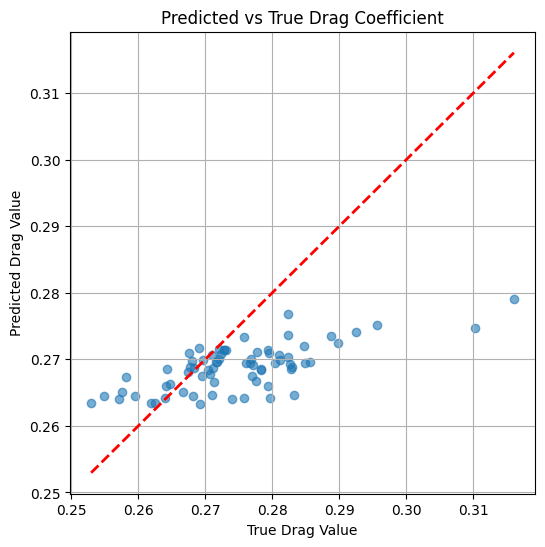

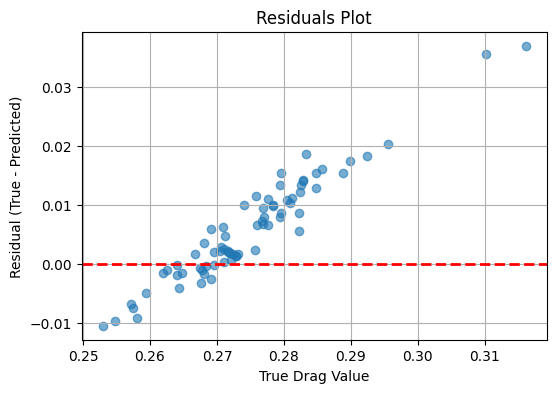

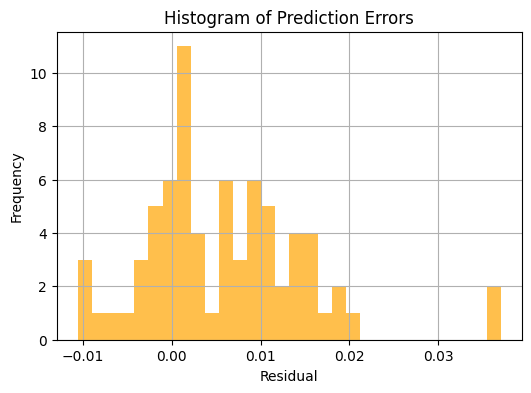

In [ ]:
# Assuming `model` is your RegDGCNN instance and `test_loader` is ready
checkpoint_path = "models/RegDGCNN_DrivAer_best.pth"
preds, targets = inference_and_plot(model, test_loader, checkpoint_path)

## Future Enhancement: 
1. Scale the Drag values for better training. 
2. Use Adaptive sampling.